In [28]:
%load_ext autoreload
%matplotlib inline

In [30]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import helpfunction as helper

In [43]:
%autoreload

In [17]:
outdir= './output/FlashHypo/'
inputdir = './input/'  

sample_names = ['nue','nu','on','off']
file_names = [next((s for s in os.listdir(inputdir) if "NueCC_"+sample+"_" in s), None) for sample in sample_names]
print(file_names)
str_ = "MCC9 November: "
sample_names_title = dict(zip(sample_names, [r"Intrinsic $\nu_e$", r"BNB $\nu$", r"BNB on (4.4e19)", r"BNB off (data)"]))

['NueCC_nue_mcc9_nov.root', 'NueCC_nu_mcc9_nov.root', 'NueCC_on_mcc9_nov.root', 'NueCC_off_mcc9_nov.root']


In [18]:
def search_unsorted(index_large, values_large, index_subset):
    if (len(index_large)!=len(values_large)):
        return -1
    sorter = np.argsort(index_large)
    return values_large[sorter][np.searchsorted(index_large[sorter], index_subset)]

In [27]:
file_flashes = {}
file_slices = {}
file_events = {}
for i, (idx, fn) in enumerate(zip(sample_names, file_names)):
    file_flashes[idx] = uproot.open(inputdir+fn)['pandoraFlashEventBuilding/flashes']
    file_slices[idx] = uproot.open(inputdir+fn)['pandoraFlashEventBuilding/slices']
    file_events[idx] = uproot.open(inputdir+fn)['pandoraFlashEventBuilding/events']

### 2(H-O)/(H+O)-plot

In [22]:
this_sample = "nue"
f_flashes = file_flashes[this_sample]
f_slices = file_slices[this_sample]

flash_ids = f_flashes.array("evt_time_nsec")
flash_pes = f_flashes.array("peSpectrum")

slice_purity = f_slices.array("purity")>0.8
slice_completeness = f_slices.array("completeness")>0.8
slice_hypos = f_slices.array("peHypothesisSpectrum")
slice_flashmatched = (slice_hypos.counts==32) & (slice_hypos.sum()>0.0)
slice_mask = slice_purity & slice_completeness & slice_flashmatched
slice_ids = f_slices.array("evt_time_nsec")[slice_mask]
slice_hypos = np.array(slice_hypos[slice_mask])

In [23]:
slice_pe = np.array(search_unsorted(flash_ids, flash_pes, slice_ids))

# 2(H-O)/(H+O)
a = 2*(slice_hypos-slice_pe)
b = (slice_hypos+slice_pe)
y_vals = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

In [24]:
y = np.nan_to_num(y_vals).T.flatten()
x = np.repeat(range(32),len(y_vals))
mask = y!=0

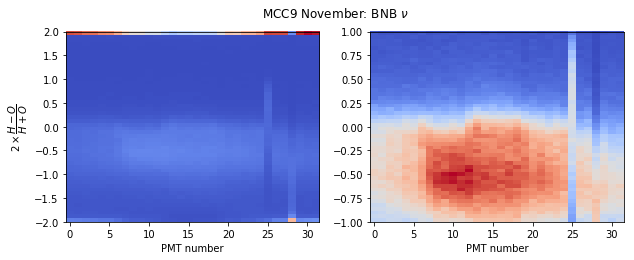

In [12]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10,3.5))

ax[0].hist2d(x[mask],y[mask], range=((-0.5,31.5),(-2,2)), bins=(32,50), cmap="coolwarm")
ax[1].hist2d(x[mask],y[mask], range=((-0.5,31.5),(-1,1)), bins=(32,50), cmap="coolwarm")
ax[0].set_ylabel(r"$2 \times \dfrac{H-O}{H+O}$")
ax[0].set_xlabel(r"PMT number")
ax[1].set_xlabel(r"PMT number")

fig.suptitle(str_+sample_names[this_sample])
fig.savefig(outdir+"nu.pdf", bbox_inches='tight')

(array([ 3481.,  2424.,  4431.,  6984.,  8348.,  4336.,   988.,   530.,
          409., 17112.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <a list of 10 Patch objects>)

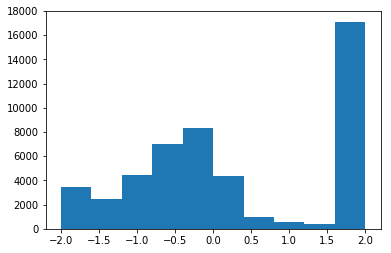

In [25]:
pmt0 = list(np.nan_to_num(y_vals).T[0])
plt.hist(pmt0, range=(-2,2))

### Single flash event viewer

The combination of event, subrun and run was found 3 times in the sample.
Taking the first one...

Run 1 , Subrun 560 , Event 11183  found! 
 ------------------------------

--- EVENT INFO ---
nFlashes :	 1
hasBeamFlash :	 True
nSlices :	 5
nSlicesAfterPrecuts :	 1
foundATargetSlice :	 True
nuCCNC :	 0
nuEnergy :	 0.7394125
leptonEnergy :	 0.4852529
nuInteractionTime :	 3633.1887
nuPdgCode :	 12
nuVertexX :	 100.75864
nuVertexY :	 55.153923
nuVertexZ :	 520.9212

--- FLASH INFO ---
time :	 [3.69125]
centerY :	 [6.5169935]
centerZ :	 [542.2384]
widthY :	 [43.86187]
widthZ :	 [105.7769]
totalPE :	 [2202.1165]
inBeamWindow :	 [ True]
isBeamFlash :	 [ True]

--- SLICE INFO ---
hasDeposition :	 [ True  True  True  True  True]
totalCharge :	 [50157.496 19578.129 54153.734 13920.553  7400.84 ]
centerX :	 [ 95.140884 216.36554   88.22985  148.18013  208.7209  ]
centerY :	 [ 50.010834  17.52477   33.912777 104.70282  -94.50838 ]
centerZ :	 [128.7582   454.59784  541.65643   27.432934 571.85284 

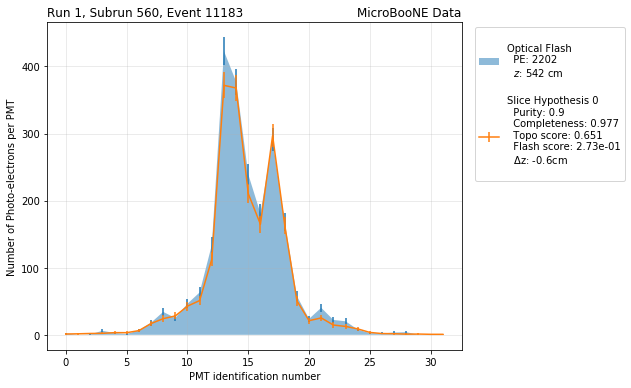

In [49]:
sample = "nue"
run = 1
subrun = 560
event = 11183

sample_dict = {'events': file_events[sample],
               'flashes': file_flashes[sample],
               'slices': file_slices[sample]
              }

helper.SingleEventViewer(run,subrun,event, sample_dict, save_plot=True)

In [ ]:
# Add the log(charge/light)-x_center field: xcl_ratio
#for sample, sample_dict in file_dict.items():
#    d = sample_dict['slices']
#    sample_dict['slices'][b'xcl_ratio'] = m_xcl*np.log10(d[b'chargeToLightRatio'])- d[b'centerX']

In [ ]:
# Save the PE values of beam flashes in a seperate numpy array:
# For the rolling sample, We only want to compare the PE rates with the run3/4 part
flashPE = []
sliceHypothesisPE = []
for sample in dict_names: 
    print(sample)
    mask = file_dict[sample]['flashes'][b'isBeamFlash']
    print(sum(mask))
    if(sample=='on_rolling'):
        mask = mask & (file_dict[sample]['flashes'][b'run']>13697)
    temp = file_dict[sample]['flashes'][b'peSpectrum'][mask]
    flashPE.append(temp.flatten().reshape(len(temp),32).T)
    del file_dict[sample]['flashes'][b'peSpectrum']
    
    mask = file_dict[sample]['slices'][b'isConsideredByFlashId']
    if(sample=='on_rolling'):
        mask = mask & (file_dict[sample]['slices'][b'run']>13697)
    temp = file_dict[sample]['slices'][b'peHypothesisSpectrum'][mask]
    sliceHypothesisPE.append(temp.flatten().reshape(sum(temp.counts==32),32).T)
    del file_dict[sample]['slices'][b'peHypothesisSpectrum']

In [ ]:
# Make a comparison of the average PE per PMT in the way marco does!

x_data = np.repeat(range(flashPE[3].shape[0]),flashPE[3].shape[1])
y_data = flashPE[3].flatten()
H_off, xedges, yedges = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))
x_data = np.repeat(range(flashPE[2].shape[0]),flashPE[2].shape[1])
y_data = flashPE[2].flatten()
H_on, _, _ = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))
H = H_on-H_off*scale_off
X, Y = np.meshgrid(xedges, yedges)

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_on.T, cmap='coolwarm', vmin=0)
ax.set_xticks(rangePMT)
fig.colorbar(im)
ax.set_title('PE per PMT: BNB On (run 1)', loc='left')
ax.set_title(title_str, loc='right')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.tight_layout()
plt.show()

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H.T, cmap='coolwarm', vmin=0)
ax.set_xticks(rangePMT)
ax.set_title('PE per PMT: BNB On - BNB Off (run 1)', loc='left')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.colorbar(im)
fig.tight_layout()
plt.show()

x_data = np.repeat(range(flashPE[1].shape[0]),flashPE[1].shape[1])
y_data = flashPE[1].flatten()
H_mc, xedges, yedges = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_mc.T, cmap='coolwarm', vmin=0)
ax.set_xticks(rangePMT)
ax.set_title(r'PE per PMT: BNB $\nu$ (MC)', loc='left')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.colorbar(im)
fig.tight_layout()
plt.show()

In [135]:
mean_mc = np.mean(flashPE[1],axis=1)
mean_on = np.mean(flashPE[2],axis=1)
mean_off = np.mean(flashPE[3],axis=1)

print("BNB on ", mean_on)
print("BNB off ", mean_off)
print("BNB MC ", mean_mc)

fig,ax = plt.subplots(ncols=8,nrows=4,figsize=(12*gr,12))
ax=ax.flatten()

for i,(pe_on,pe_off, pe_mc) in enumerate(zip(flashPE[2], flashPE[3], flashPE[1])):
    ax[i].hist(pe_mc, density=1, range=(0,300), label='MC  : {0:.0f}'.format(np.mean(pe_mc)), histtype='step', bins=15)
    ax[i].hist(pe_on, density=1, range=(0,300), label='BNB On: {0:.0f}'.format(np.mean(pe_on)), histtype='step', bins=15)
    ax[i].hist(pe_off, density=1, range=(0,300), label='BNB On: {0:.0f}'.format(np.mean(pe_off)), histtype='step', bins=15)
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e-4,0.05)
    ax[i].legend(title="PMT "+str(i))
fig.tight_layout()
plt.savefig(outdir+"pe_per_pmt_data_mc.pdf", bbox_inches="tight")
plt.show()

ratio_on  = mean_on/mean_mc
ratio_off = mean_off/mean_mc

plt.errorbar(rangePMT, ratio_on, xerr= 0.5, fmt='none', label='BNB On')
plt.errorbar(rangePMT, ratio_off, xerr= 0.5, fmt='none', label='BNB Off')

plt.axhline(1, color='C2', label='MC')
plt.legend(loc = 'lower left')
plt.xlabel('PMT identification number')
plt.ylabel('Fraction of mean PE')
plt.title('Mean #PE Data versus MC')
plt.ylim(0,1.3)
plt.xlim(-0.5,31.5)
plt.savefig(outdir+"pe_per_pmt_data_mc_ratio.pdf", bbox_inches="tight")

NameError: name 'flashPE' is not defined

In [136]:
x_data = np.repeat(range(flashPE[4].shape[0]),flashPE[4].shape[1])
y_data = flashPE[4].flatten()
H_on_rolling, xedges, yedges = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_on.T, cmap='coolwarm', vmin=0)
ax.set_xticks(rangePMT)
fig.colorbar(im)
ax.set_title('PE per PMT: BNB On (run 1)', loc='left')
ax.set_title(title_str, loc='right')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.tight_layout()
plt.show()

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_on_rolling.T, cmap='coolwarm', vmin=0)
ax.set_xticks(rangePMT)
ax.set_title('PE per PMT: BNB On (run 3/4)', loc='left')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.colorbar(im)
fig.tight_layout()
plt.show()

NameError: name 'flashPE' is not defined

In [137]:
mean_1 = np.mean(flashPE[2],axis=1)
mean_34 = np.mean(flashPE[4],axis=1)
std34 = np.std(flashPE[4],axis=1)/np.sqrt(np.size(flashPE[4], axis=1))/mean_1
ratio = mean_34/mean_1
plt.errorbar(rangePMT, ratio, yerr=std34, xerr= 0.5, fmt='none')
plt.axhline(np.mean(ratio), color='C1', label='Mean  : {0:.2f}'.format(np.mean(ratio)))
plt.legend(loc = 'lower left')
plt.xlabel('PMT identification number')
plt.ylabel('Fraction of mean PE')
plt.title('Mean #PE run 1 versus run 1/2')
plt.ylim(0,1.3)
plt.xlim(-0.5,31.5)
plt.savefig(outdir+"pmtperun12.pdf", bbox_inches="tight")

NameError: name 'flashPE' is not defined

In [138]:
fig,ax = plt.subplots(ncols=8,nrows=4,figsize=(12*gr,12))
ax=ax.flatten()

for i,(pe_1,pe_34) in enumerate(zip(flashPE[2],flashPE[4])):
    ax[i].hist(pe_1, density=1, range=(0,300), label='run 1  : {0:.0f}'.format(np.mean(pe_1)), histtype='step', bins=15)
    ax[i].hist(pe_34, density=1, range=(0,300), label='run 3/4: {0:.0f}'.format(np.mean(pe_34)), histtype='step', bins=15)
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e-4,0.05)
    ax[i].legend(title="PMT "+str(i))
fig.tight_layout()
plt.show()

NameError: name 'gr' is not defined